# Reducing Phenotypic Effects to Improve Multi-site Autism Classification Performance

In this tutorial, we demonstrate how to leverage **patient phenotypic information** to reduce **site-specific biases** in functional connectivity data using **domain adaptation**, with the goal of improving **multi-site autism classification**.

This notebook builds on the work of **Kunda et al. (IEEE TMI, 2022)**, which introduced a second-order functional connectivity representation called **Tangent-Pearson**, the tangent embedding of the Pearson correlation matrix. The original work also applied domain adaptation to reduce site dependencies in fMRI-derived features, using **site labels** as the domain information.

We extend this approach by incorporating a **richer set** of phenotypic variables, such as sex, handedness, age, and eye status into the domain adaptation framework. This enables more effective harmonization across data collected from different imaging sites.

---

**Objectives**

1.	**Load** the ABIDE dataset using different preprocessing pipelines and brain atlases.
2.	**Extract** functional connectivity features from ROI-based time series.
3.	**Preprocess** phenotypic variables for use in domain adaptation, and obtain class labels (ASD vs CONTROL) and site labels.
4.	**Build** a training and evaluation pipeline to assess classification performance under various domain adaptation strategies.
5.	**Interpret** the learned model by extracting weights for pairwise ROI feature importance and visualizing them using a connectome plot.

# Setup

As a starting point, we will install the required packages and load a set of helper functions to assist throughout this tutorial. To keep the output clean and focused on interpretation, we will also suppress warnings.

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

## Packages

The main packages required for this tutorial are PyKale and Nilearn.

**PyKale** is an open-source interdisciplinary machine learning library developed at the University of Sheffield, with a focus on applications in biomedical and scientific domains.

**Nilearn** is a Python library for neuroimaging analysis, widely used for processing and visualizing functional MRI (fMRI) data.

In [2]:
!pip install --quiet git+https://github.com/pykale/pykale@main nilearn \
    && echo "PyKale and Nilearn installed successfully ✅" \
    || echo "Failed to install PyKale and Nilearn ❌"

PyKale and Nilearn installed successfully ✅


## Helper Functions

The helper functions used in this tutorial are adapted from the [source code](https://github.com/zaRizk7/abide-demo), which was originally developed to demonstrate the use of containers for improving reproducibility and reusability in machine learning experiments.

### Feature Extraction

Includes functionality for:
- **Imputation** of missing phenotypic values,
- **Categorical encoding** of variables such as sex, handedness, and eye status,
- **Standardization** of continuous features like age and FIQ,
- **Chaining functional connectivity transformations** (e.g., Pearson, Tangent) to extract features from ROI-based time series.

In [3]:
import logging

import numpy as np
import pandas as pd
from nilearn.connectome import ConnectivityMeasure
from sklearn.preprocessing import StandardScaler
from sklearn.utils._param_validation import (
    Integral,
    Interval,
    StrOptions,
    validate_params,
)

SELECTED_PHENOTYPES = [
    "SUB_ID",
    "SITE_ID",
    "SEX",
    "AGE_AT_SCAN",
    "FIQ",
    "HANDEDNESS_CATEGORY",
    "EYE_STATUS_AT_SCAN",
    "DX_GROUP",
]

MAPPING = {
    "SEX": {1: "MALE", 2: "FEMALE"},
    "HANDEDNESS_CATEGORY": {
        "L": "LEFT",
        "R": "RIGHT",
        "Mixed": "AMBIDEXTROUS",
        "Ambi": "AMBIDEXTROUS",
        "L->R": "AMBIDEXTROUS",
        "R->L": "AMBIDEXTROUS",
        "-9999": "LEFT",
        np.nan: "LEFT",
    },
    "EYE_STATUS_AT_SCAN": {1: "OPEN", 2: "CLOSED"},
    "DX_GROUP": {1: "ASD", 2: "CONTROL"},
}

AVAILABLE_FC_MEASURES = {
    "pearson": "correlation",
    "partial": "partial correlation",
    "tangent": "tangent",
    "covariance": "covariance",
    "precision": "precision",
}


@validate_params(
    {
        "data": [pd.DataFrame],
        "standardize": [StrOptions({"site", "all"}), "boolean"],
        "verbose": ["verbose"],
    },
    prefer_skip_nested_validation=False,
)
def process_phenotypic_data(data, standardize=False, verbose=0):
    """Process phenotypic data to impute missing values and and encode categorical
    variables including sex, handedness, eye status at scan, and diagnostic group.

    Parameters
    ----------
    data : pd.DataFrame of shape (n_subjects, n_phenotypes)
        The phenotypes data to be processed.

    standardize: boolean or str of ("site", "all")
                Standardize FIQ and age. The default is 0.
                Setting to True or "all" standardizes the
                values over all subjects while "site"
                standardizes according to the site.

    verbose : int, optional
            The verbosity level. The default is 0.
            verbose > 0 will log the current processing step.

    Returns
    -------
    labels : pd.Series of shape (n_subjects)
            The encoded classification group. 0 is "CONTROL" and
            1 is "ASD"

    phenotypes : pd.DataFrame of shape (n_subjects, n_selected_phenotypes)
                The processed selected phenotype data with imputed values.
    """
    logger = logging.getLogger("feature_extraction.process_phenotypic_data")
    if verbose > 0:
        logger.setLevel(logging.INFO)
        logger.info("Imputing missing values and encoding handedness...")

    # Avoid in-place modification
    data = data.copy()

    # Check for missing values, either -9999 or NaN
    # and impute them with FIQ = 100 following original code.
    fiq = data["FIQ"].copy()
    data["FIQ"] = fiq.where((fiq != -9999) & (~np.isnan(fiq)), 100)

    # Standardize FIQ and age by site
    if standardize == "site":
        for site in data["SITE_ID"].unique():
            mask = site == data["SITE_ID"]
            values = data.loc[mask, ["AGE_AT_SCAN", "FIQ"]]
            values = StandardScaler().fit_transform(values)
            data.loc[mask, ["AGE_AT_SCAN", "FIQ"]] = values
    elif standardize:
        values = data.loc[:, ["AGE_AT_SCAN", "FIQ"]]
        values = StandardScaler().fit_transform(values)
        data.loc[:, ["AGE_AT_SCAN", "FIQ"]] = values

    # Encode categorical variables to be more explicit categorical
    # values. For handedness, if we found missing values, we
    # impute them by using 'LEFT' as default. Values
    # like 'Ambi', 'Mixed', 'L->R', and 'R->L' are mapped to
    # 'AMBIDEXTROUS'. The rest of the values are mapped to 'LEFT' or 'RIGHT'
    # for 'L' or 'R' respectively.
    for key in MAPPING:
        values = data[key].copy().map(MAPPING[key])
        data[key] = values.astype("category")

    # Subsets the phenotypes
    data = data[SELECTED_PHENOTYPES].set_index("SUB_ID")

    # Separate the class labels, sites, and phenotypes
    labels = data["DX_GROUP"].map({"CONTROL": 0, "ASD": 1})
    sites = data["SITE_ID"]
    phenotypes = data.drop(columns=["DX_GROUP"])
    # One-hot encode categorical valued phenotypes
    phenotypes = pd.get_dummies(phenotypes)

    if verbose > 0:
        logger.info("Imputation and encoding completed.")

    return labels, sites, phenotypes


@validate_params(
    {
        "data": ["array-like"],
        "measures": [list],
        "verbose": ["verbose"],
    },
    prefer_skip_nested_validation=False,
)
def extract_functional_connectivity(data, measures=["pearson"], verbose=0):
    """Extract functional connectivity features from time series data.

    Parameters
    ----------
    data : list[array-like] of shape (n_subjects,)
        An array of numpy arrays, where each array is a time series of shape (t, n_rois).
        The time series data for each subject.

    measures : list[str], optional
        A list of connectivity measures to use for feature extraction.
        The default is ["pearson"].
        Supported measures are "pearson", "partial", "tangent", "covariance", and "precision".
        Multiple measures can be specified as a list to compose a higher-order measure.

    verbose : int, optional
        The verbosity level. The default is 0.
        verbose > 0 will log the current processing step.

    Returns
    -------
    features : array-like
        An array of shape (n_subjects, n_features) containing the extracted features.
        n_features is equal to `n_rois * (n_rois - 1) / 2` for each subjects.
    """
    if verbose > 0:
        logger = logging.getLogger("feature_extraction.extract_functional_connectivity")
        logger.setLevel(logging.INFO)
        logger.info("Extracting functional connectivity features...")
        logger.info(f"Using measures: {measures}")

    for i, k in enumerate(reversed(measures), 1):
        k = AVAILABLE_FC_MEASURES.get(k)

        # If it is the last transformation, vectorize and discard the diagonal
        # of shape (n_rois * (n_rois - 1) / 2)
        islast = i == len(measures)
        measure = ConnectivityMeasure(kind=k, vectorize=islast, discard_diagonal=islast)
        data = measure.fit_transform(data)

    if verbose > 0:
        logger.info("Functional connectivity features extracted.")

    return data

### Trainer

Defines the **hyperparameter search spac**e and provides a **wrapper function** to train the classification pipeline, with or without domain adaptation.

Providing various search strategies (e.g., grid or randomized search) and integrates seamlessly with cross-validation and MIDA-based feature transformation when enabled.

In [4]:
import logging

import numpy as np
from kale.pipeline.mida_trainer import MIDATrainer
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import get_scorer_names
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, check_cv
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.utils._param_validation import (
    Integral,
    Interval,
    StrOptions,
    validate_params,
)

__all__ = ["create_trainer"]

# Inverse regularization coefficients for the classifiers
# For Ridge (alpha) and MIDA (mu and eta), we use 1 / (2C)
C = np.logspace(start=-15, stop=15, num=30 + 1, base=2)

CLASSIFIER = {
    "logistic": LogisticRegression(),
    "svm": LinearSVC(),
    "ridge": RidgeClassifier(),
}

CLASSIFIER_GRID = {
    "logistic": {"C": C},
    "svm": {"C": C},
    "ridge": {"alpha": 1 / (2 * C)},
}

MIDA_GRID = {
    "num_components": [32, 64, 128, 256, None],
    "mu": 1 / (2 * C),
    "eta": 1 / (2 * C),
    "ignore_y": [True, False],
}
MIDA_GRID = {f"domain_adapter__{key}": value for key, value in MIDA_GRID.items()}


@validate_params(
    {
        "classifier": [StrOptions({"logistic", "svm", "ridge"})],
        "mida": ["boolean"],
        "search_strategy": [StrOptions({"grid", "random"})],
        "cv": ["cv_object"],
        "scoring": [StrOptions(set(get_scorer_names())), list, None],
        "num_solver_iterations": [Interval(Integral, 1, None, closed="left")],
        "num_search_iterations": [Interval(Integral, 1, None, closed="left")],
        "num_jobs": [Integral, None],
        "random_state": ["random_state"],
        "verbose": ["verbose"],
    },
    prefer_skip_nested_validation=False,
)
def create_trainer(
    classifier="logistic",
    mida=False,
    search_strategy="grid",
    cv=None,
    scoring=None,
    num_solver_iterations=100,
    num_search_iterations=10,
    num_jobs=None,
    random_state=None,
    verbose=0,
):
    """Create a trainer for a classification model.

    Parameters
    ----------
    classifier : str, default="logistic"
        The classifier to use. Can be "logistic", "svm", or "ridge".

    mida : bool, default=False
        Whether to use MIDA for site-dependency reduction.

    search_strategy : str, default="grid"
        The search strategy for hyperparameter tuning. Can be "grid" or "random".

    cv : int, cross-validation generator, or iterable, default=None
        The cross-validation splitting strategy. If None, the default 5-fold
        cross-validation is used.

    scoring : str, list of str, callable, or None, default=None
        A single string or a list of strings to use as the scoring metric(s).
        If None, the default scoring metric for the classifier is used.

    num_solver_iterations : int, default=100
        The number of iterations for the solver. This is used to set the
        max_iter parameter of the classifier.

    num_search_iterations : int, default=10
        The number of iterations for the random search. This is only used
        if search_strategy is "random".

    num_jobs : int, default=None
        The number of jobs to run in parallel with joblib.Parallel. If None,
        the number of jobs is set to run on a single core.

    random_state : int, RandomState instance, or None, default=None
        The random seed for the random number generator. If None, the
        random state is not set.

    Returns
    -------
    trainer : sklearn.model_selection.BaseSearchCV or MIDATrainer
        The model trainer object. This can be either a GridSearchCV,
        RandomizedSearchCV, or MIDATrainer object.
    """
    if verbose > 0:
        logger = logging.getLogger("modeling.create_trainer")
        logger.setLevel(logging.INFO)

        logger.info(f"Creating trainer with classifier: {classifier}")
        logger.info(f"Using MIDA: {mida}")
        logger.info(f"Search strategy: {search_strategy}")
        logger.info(f"Scoring: {scoring}")
        logger.info(f"Number of solver iterations: {num_solver_iterations}")
        logger.info(f"Number of search iterations: {num_search_iterations}")
        logger.info(f"Number of jobs: {num_jobs}")
        logger.info(f"Random state: {random_state}")

    # Generate classifier with its parameter grid
    clf = clone(CLASSIFIER[classifier])
    clf.set_params(max_iter=num_solver_iterations, random_state=random_state)
    param_grid = clone(CLASSIFIER_GRID[classifier], safe=False)

    # Update with MIDA's parameters if we are using MIDA
    if mida:
        param_grid.update(MIDA_GRID)

    # Construct trainer
    trainer_args = {
        "cv": check_cv(cv, [0, 1], classifier=True),
        "scoring": scoring,
        "refit": scoring[0] if isinstance(scoring, list) else scoring,
        "n_jobs": num_jobs,
        "error_score": "raise",
        "verbose": verbose,
    }

    if verbose > 0:
        logger.info("Finished constructing trainer.")

    if mida:
        return MIDATrainer(
            estimator=clf,
            param_grid=param_grid,
            search_strategy=search_strategy,
            num_iter=num_search_iterations,
            random_state=random_state,
            **trainer_args,
        )

    if search_strategy == "grid":
        return GridSearchCV(estimator=clf, param_grid=param_grid, **trainer_args)

    return RandomizedSearchCV(
        estimator=clf,
        param_distributions=param_grid,
        n_iter=num_search_iterations,
        random_state=random_state,
        **trainer_args,
    )

### Evaluation

Contains a function to **aggregate the top-1 cross-validation scores** for each defined model, selecting the best-performing configuration per model based on a specified evaluation metric.

In [5]:
import pandas as pd
from collections import defaultdict
from sklearn.utils._param_validation import validate_params, StrOptions

# Mapping for model and score display names
MODEL = ["baseline", "site_only", "all_phenotypes"]
MODEL = {model: " ".join(model.split("_")).title() for model in MODEL}

SCORE = ["accuracy", "precision", "recall", "f1"]
SCORE = {score: score.title() for score in SCORE}
SCORE["roc_auc"] = "AUROC"
SCORE["matthews_corrcoef"] = "MCC"


@validate_params(
    {"cv_results": [dict], "sort_by": [StrOptions(set(SCORE))]},
    prefer_skip_nested_validation=True,
)
def compile_results(cv_results, sort_by):
    """
    Compile and summarize cross-validation results into a formatted DataFrame.

    Parameters
    ----------
    cv_results : dict of str -> pd.DataFrame or dict of str -> dict of str -> list
        Dictionary mapping model names to cross-validation results.
        Each entry should either be a DataFrame or a dictionary of dictionary of list.
    sort_by : str
        Metric to use for selecting the best-performing model variant.
        Available ones include: "accuracy", "precision", "recall", "f1", "roc_auc",
        and "matthews_corrcoef".

    Returns
    -------
    compiled_results : pd.DataFrame
        Summary table with models as rows and formatted score strings (mean ± std) as columns.
    """
    compiled_results = defaultdict(list)

    for model in cv_results:
        # Ensure results are in DataFrame format
        if not isinstance(cv_results[model], pd.DataFrame):
            cv_results[model] = pd.DataFrame(cv_results[model])

        # Extract all available test scores
        scores = [
            score.replace("rank_test_", "")
            for score in cv_results[model].columns
            if "rank_test" in score
        ]

        # Select the best row (lowest rank) based on the given metric
        cv_result = cv_results[model].sort_values(f"rank_test_{sort_by}").iloc[0]

        compiled_results["Model"].append(MODEL[model])

        for score in scores:
            mean_score = cv_result[f"mean_test_{score}"]
            std_score = cv_result[f"std_test_{score}"]
            compiled_results[SCORE[score]].append(f"{mean_score:.4f} ± {std_score:.4f}")

    # Convert to DataFrame and index by model name
    compiled_results = pd.DataFrame(compiled_results)
    compiled_results = compiled_results.set_index("Model")

    return compiled_results


### Visualization

Provides utility functions to:
- Generate **pairwise ROI labels**,
- Extract the **top-p most important weights** and convert them into a **symmetric matrix**,
- Wrap the process of **plotting connectomes** for visual interpretation of model-derived feature importances.

In [6]:
import numpy as np
import pandas as pd
from itertools import combinations
from matplotlib.cm import get_cmap
from nilearn.plotting import plot_connectome
from sklearn.utils._param_validation import Interval, validate_params, Real


@validate_params(
    {"rois": ["array-like"], "sep": [str]}, prefer_skip_nested_validation=True
)
def get_pairwise_rois(rois, sep="---"):
    """
    Generate all unique ROI pair labels (upper triangle only).

    Parameters
    ----------
    rois : array-like of str or int
        List of region-of-interest (ROI) names.
    sep : str, optional
        Separator string used to join ROI pairs, by default '---'.

    Returns
    -------
    pairs : np.ndarray
        Array of ROI pair strings in the format "ROI1 --- ROI2".
    """
    pairs = [f" {sep} ".join((a, b)) for a, b in combinations(rois, 2)]
    return np.array(pairs)


@validate_params(
    {
        "weights": ["array-like"],
        "labels": ["array-like"],
        "coords": ["array-like"],
        "p": [Interval(Real, 0, 1, closed="neither")],
        "sep": [str],
    },
    prefer_skip_nested_validation=True,
)
def get_top_symmetric_weight(weights, labels, coords, p=0.001, sep="---"):
    """
    Construct a symmetric weight matrix for top-p ROI pairs.

    Parameters
    ----------
    weights : array-like
        1D array of weights corresponding to pairwise ROI combinations.
    labels : array-like of str or int
        List of all ROI names or indices in the original data.
    coords : array-like
        Coordinates of each ROI, shape (n_rois, 3).
    p : float, optional
        Proportion of top weights to retain (default is 0.001).
    sep : str, optional
        Separator used in ROI pair labels, by default '---'.

    Returns
    -------
    sym_weights : array-like
        Symmetric matrix of selected top weights (n_top_rois, n_top_rois).
    top_roi_labels : array-like
        Labels of ROIs included in the top-p weight pairs.
    top_roi_coords : array-like
        Coordinates corresponding to `top_roi_labels`.
    """
    weights = pd.Series(np.copy(weights), index=get_pairwise_rois(labels))
    rank = weights.abs().nlargest(int(len(weights.index) * p))
    weights = weights[rank.index]

    pairs = np.array([[roi.strip() for roi in col.split(sep)] for col in weights.index])
    unique = np.unique(pairs)

    label_to_index = {label: idx for idx, label in enumerate(labels)}
    indices = [label_to_index[roi] for roi in unique]

    top_labels = np.array(labels)[indices]
    top_coords = np.array(coords)[indices]
    mappings = {roi: idx for idx, roi in enumerate(top_labels)}

    sym_weights = np.zeros([len(indices)] * 2)
    for (roi1, roi2), weight in zip(pairs, weights.values):
        i, j = mappings[roi1], mappings[roi2]
        sym_weights[i, j] = weight
        sym_weights[j, i] = weight

    return sym_weights, top_labels, top_coords


@validate_params(
    {
        "weights": ["array-like"],
        "labels": ["array-like"],
        "coords": ["array-like"],
        "p": [Interval(Real, 0, 1, closed="neither")],
        "cmap": [str],
        "marker_size": [Real],
        "legend_params": [dict],
    },
    prefer_skip_nested_validation=True,
)
def visualize_connectome(
    weights, labels, coords, p=1e-3, cmap="tab20", marker_size=100, legend_params={}
):
    """
    Visualize the top-p weighted ROI connections as a symmetric connectome plot.

    This function selects the top proportion `p` of the largest (by absolute value)
    weights between region pairs, constructs a symmetric connectivity matrix,
    and plots the corresponding connectome using `nilearn.plotting.plot_connectome`.

    Parameters
    ----------
    weights : array-like of shape (n_edges,)
        Weights assigned to each unique pair of ROIs, typically from a model or analysis.
        These are expected to align with the order of ROI pairs generated from `labels`.

    labels : array-like of shape (n_rois,)
        List of ROI (region of interest) names corresponding to the original brain atlas.

    coords : array-like of shape (n_rois, 3)
        3D coordinates for each ROI, used to place nodes in the plot.

    p : float, optional
        Proportion of the top-weighted connections (by absolute value) to include.
        Must be in the open interval (0, 1). Default is 0.001 (0.1%).

    cmap : str, optional
        Matplotlib colormap name used to assign colors to ROI nodes. Default is 'tab20'.

    marker_size : float, optional
        Size of ROI node markers in the connectome plot. Default is 100.

    legend_params : dict, optional
        Additional keyword arguments to pass to the plot's legend (e.g., location, fontsize).

    Returns
    -------
    proj : nilearn.plotting.displays._projectors.ConnectivityProjection
        A `nilearn` projection object with the plotted connectome. This object supports
        further customization (e.g., adding markers, saving the figure).

    Notes
    -----
    - This function assumes the weights are symmetric or that symmetry should be imposed.
    - Useful for visualizing model interpretability or structural/functional connectivity.
    """
    marker_colors = get_cmap(cmap)(np.arange(len(labels)))
    sym_weights, labels, coords = get_top_symmetric_weight(weights, labels, coords, p)
    proj = plot_connectome(sym_weights, coords, colorbar=True)

    for i in range(len(labels)):
        proj.add_markers(
            [coords[i]],
            marker_color=marker_colors[i],
            marker_size=marker_size,
            label=labels[i],
        )

    proj.axes[next(iter(proj.axes))].ax.legend(**legend_params)

    return proj


# Pipeline

## Resting-state fMRI Preprocessing

Typically, raw fMRI scans require extensive preprocessing before they can be used in a machine learning pipeline. However, the **ABIDE** dataset provides several preprocessed derivatives, which can be downloaded directly from the [Preprocessed Connectomes Project (PCP)](https://preprocessed-connectomes-project.org/abide/), eliminating the need for manual preprocessing.

In this tutorial, we focus on the following preprocessing options:
- `atlas`: The **brain atlas** used to **extract ROI time series**. Available options include: `"aal"`, `"cc200"`, `"cc400"`, `"dosenbach160"`, `"ez"`, `"ho"`, and `"tt"`. Default: `"aal"`
- `bp`: Whether to apply **band-pass filter** to the time series between [0.01, 0.1] Hz. Default: `False`
- `gsr`: Whether to apply **global signal regression** to remove shared global noise from the signals. Default: `False`
- `qc`: Whether to include **only scans that passed all quality checks** provided by the dataset curators. Default: `True`

In [7]:
from nilearn.datasets import fetch_abide_pcp

# Define preprocessing options
atlas = "aal"      # Brain atlas used to extract ROI time series (e.g., AAL atlas)
bp = False         # Apply band-pass filtering (0.01–0.1 Hz) to remove low- and high-frequency noise
gsr = False        # Do not apply global signal regression (GSR)
qc = True          # Include all subjects regardless of quality control status

# Fetch the preprocessed ABIDE dataset using the specified preprocessing options
# This returns a dictionary containing region-wise time series and associated metadata
dataset = fetch_abide_pcp(
    derivatives=[f"rois_{atlas}"],     # Select the atlas-specific ROI time series (e.g., 'rois_aal')
    band_pass_filtering=bp,            # Whether to apply band-pass filtering
    global_signal_regression=gsr,      # Whether to apply global signal regression
    quality_checked=qc,                # Whether to include only subjects that passed QC
)

[get_dataset_dir] Dataset found in /home/zarizky/nilearn_data/ABIDE_pcp


## Phenotype Preprocessing 

The phenotypic information in the dataset contains several missing values. We impute and encode it to make it suitable for modeling.

**Categorical Variables**

The following categorical phenotypes are used and will be **one-hot encoded**:
- `SITE_ID`
- `SEX`
- `HANDEDNESS_CATEGORY`
- `EYE_STATUS_AT_SCAN`

**Continuous Variables**

The following continuous phenotypes will optionally be **standardized**:
- `AGE_AT_SCAN`
- `FIQ`

Possible options to `standardize` the continuous phenotypes includes:
- `"all"` or `True`: Standardize across all subjects
- `"site"`: Standardize within each site
- `False`: No standardization

**Handling Missing Values**
- `HANDEDNESS_CATEGORY`: Missing values are assumed to correspond to `right-handed` subjects.
- `FIQ`: Missing values are imputed with a default score of `100`.

**Label Encoding**

The diagnostic label `DX_GROUP` is used to assign the target class:
- `CONTROL` → `0`
- `ASD` → `1`

In [8]:
standardize = "site"  # Standardize continuous phenotypes (e.g., age, FIQ) within each site

# Process the phenotypic metadata from the ABIDE dataset
# This function handles:
# - Imputation of missing values (e.g., assuming right-handed for missing handedness)
# - One-hot encoding of categorical variables (e.g., sex, site, eye status)
# - Standardization of continuous variables based on the chosen strategy ('site' or 'all')

# Returns:
# - `labels`: Binary class labels (0 = control, 1 = ASD)
# - `sites`: Site identifiers for domain adaptation
# - `phenotypes`: Feature matrix containing encoded and standardized phenotypic variables
labels, sites, phenotypes = process_phenotypic_data(dataset["phenotypic"], standardize)

## Feature Extraction

Functional MRI (fMRI) time series data often vary in temporal length. However, many machine learning models, including those used in this study require fixed-size input. To address this, a common approach in fMRI analysis is to compute the functional connectivity (e.g., correlation) between regions of interest (ROIs), resulting in a fixed-size feature representation.

Specifically, we compute a connectivity matrix for each subject, and extract the upper or lower triangular part (excluding the diagonal) to obtain a feature vector suitable for model training.

The available arguments for feature extraction are:
- `measures`: A sequence of connectivity transformations applied to the ROI time series. Supported options include: `"pearson"`, `"partial"`, `"tangent"`, `"covariance"`, and `"precision"`. Default: `["pearson"]`.

Multiple transformations can be chained to compute composite connectivity representations. For example, the **Tangent-Pearson** method proposed by *Kunda et al.* can be specified via `measures = ["tangent", "pearson"]`. This design also allows for future extensions to support higher-order connectivity features.

```{warning}
Given the long runtime needed for Tangent-Pearson, we opt to use `"pearson"` by default.
```

In [9]:
measures = ["pearson"]  # Use Pearson correlation to compute functional connectivity

# Extract functional connectivity features from ROI time series using the specified measure
# - `dataset[f"rois_{atlas}"]`: Time series data extracted from the selected brain atlas (e.g., AAL)
# - `measures`: List of connectivity measures to apply; in this case, only Pearson correlation is used
#   to compute pairwise correlations between ROI time series, resulting in a symmetric connectivity matrix

features = extract_functional_connectivity(dataset[f"rois_{atlas}"], measures)

## Modeling

We define and train machine learning models for classifying autism spectrum disorder (ASD) using functional connectivity features.

We explore different configurations including a baseline model, domain adaptation using site information, and an extended approach that incorporates additional phenotypic variables.

Each model is evaluated using cross-validation, and we analyze the impact of domain adaptation on classification performance.

### Random Seed

To ensure reproducibility across runs, we define a fixed random seed. This guarantees that all operations involving randomness, such as cross-validation splits, model initialization, and hyperparameter search to produce consistent results.

In [10]:
from sklearn.utils.validation import check_random_state

seed = 0  # Set a fixed seed for reproducibility

# Convert the seed into a numpy-compatible RandomState instance
# This ensures consistent behavior across scikit-learn functions that rely on randomness
random_state = check_random_state(seed)

### Cross-Validation Split

To evaluate model performance reliably, we define a cross-validation (CV) strategy. By default, we use **Repeated Stratified K-Fold**, which preserves class distribution across folds and supports repeated trials for more stable estimates.

Alternatively, we can also use **Leave-P-Groups-Out (LPGO)** cross-validation. This strategy is particularly useful in multi-site studies, as it ensures that data from the same group (e.g., imaging site) are not shared between training and test sets, enabling more realistic generalization assessment under domain shift.

For this tutorial we will specify several arguments:
- `split`: Defines the cross-validation strategy. `"skf"` for stratified k-fold to maintain label balance in each fold or use `"lpgo"` to evaluate generalization across sites by holding out entire groups (e.g., imaging sites). Default: `"lpgo"`
- `num_folds`: Sets how many folds to use for stratified k-fold or how many groups to leave out in LPGO. Default: `1`
- `num_cv_repeats`: Determines how many times the k-fold procedure is repeated to obtain more stable estimates (ignored when using LPGO). Default: `1`

In [11]:
from sklearn.model_selection import LeavePGroupsOut, RepeatedStratifiedKFold

split = "lpgo"         # Cross-validation split strategy
num_folds = 1         # Number of folds (or groups to leave out)
num_cv_repeats = 1    # Number of repetitions (used only for skf)

# Define the default cross-validation strategy:
# Repeated stratified k-fold maintains class distribution across folds and supports multiple repetitions
cv = RepeatedStratifiedKFold(
    n_splits=num_folds,          # Number of stratified folds
    n_repeats=num_cv_repeats,    # Number of repeat rounds
    random_state=random_state,   # Ensures reproducibility
)

# Override with leave-p-proups-out if specified
# This strategy holds out `p` unique groups (e.g., sites) per fold, enabling group-level generalization
if split == "lpgo":
    cv = LeavePGroupsOut(num_folds)  # Use group-based CV for domain adaptation or site bias evaluation

### Model Definition
We define different model configurations used for classification. Each model shares the same base classifier (e.g., logistic regression), but differs in how domain adaptation is applied:
- **Baseline**: A standard model trained directly on functional connectivity features without domain adaptation.
- **Site Only**: A domain-adapted model that uses site labels as the adaptation factor, reducing site-specific bias.
- **All Phenotypes**: An extended domain-adapted model that incorporates multiple phenotypic variables (e.g., age, sex, handedness) to further reduce inter-site variability.

We also specify the hyperparameter search strategy and other training parameters for each configuration, including:
- `classifier`: The base model to use for classification. Available options include `"logistic"` for logistic regression, `"ridge"` for ridge classifier, and `"svm"` for support vector machines. Default: `"logistic"`
- `scoring`: A list of performance metrics (e.g., accuracy, F1, AUROC) used during cross-validation.
- `num_solver_iterations`: Maximum number of iterations allowed for the solver to converge during model fitting.
- `num_search_iterations`: Number of hyperparameter combinations to evaluate in a randomized search.
- `num_jobs`: Number of CPU cores used in parallel for hyperparameter tuning and model training. Set to `-1` to use all of the available CPU cores or `-k` to use all but `k` CPU cores.
- `verbose`: Controls the verbosity of the training output. Higher values provide more detailed logs.

In [12]:
from sklearn.base import clone

# Define core training configuration
classifier = "logistic"                    # Classifier type (e.g., 'logistic', 'svm', etc.)
scoring = list(SCORE)                      # List of scoring metrics to evaluate during CV
num_solver_iterations = int(1e6)           # Max iterations for the solver to converge
num_search_iterations = 100                # Number of parameter settings sampled in randomized search
num_jobs = -4                              # Number of parallel jobs for training and CV
verbose = 1                                # Verbosity level for output

# Initialize dictionary to store trainer instances for each model configuration
trainers = {}

# Create a baseline trainer without domain adaptation (MIDA disabled)
trainers["baseline"] = create_trainer(
    classifier,               # Classifier to use
    False,                    # Do not apply MIDA (no domain adaptation)
    "grid",                   # Use grid search for hyperparameter tuning
    cv,                       # Cross-validation strategy
    scoring,                  # Evaluation metrics
    num_solver_iterations,    # Max solver iterations
    num_search_iterations,    # Max hyperparameter trials (ignored for grid search)
    num_jobs,                 # Number of parallel jobs
    random_state,             # Random seed for reproducibility
    verbose,                  # Verbosity level
)

# Create a trainer with MIDA enabled, using site labels as domain adaptation factors
trainers["site_only"] = create_trainer(
    classifier,
    True,                     # Apply MIDA for domain adaptation
    "random",                 # Use randomized search for hyperparameter tuning
    cv,
    scoring,
    num_solver_iterations,
    num_search_iterations,
    num_jobs,
    random_state,
    verbose,
)

# Clone the 'site_only' trainer to create 'all_phenotypes' trainer
# This enables reusing the same training configuration, while modifying only the input domain factors
trainers["all_phenotypes"] = clone(trainers["site_only"])

## Training and Cross-Validation

We train each model configuration using the previously defined cross-validation strategy. The training process involves fitting the model on functional connectivity features and evaluating its performance using multiple scoring metrics (e.g., accuracy, F1-score, AUROC).

For models with domain adaptation, we pass additional domain factors (such as site or phenotypic variables) to guide the alignment of feature representations. Cross-validation is performed to ensure robust performance estimates and to select the best hyperparameter configuration for each model.

In [13]:
# Define common training arguments for all models: features (X), labels (y), and group info (sites)
fit_args = {"X": features, "y": labels, "groups": sites}

# Fit the baseline model using raw features (no domain adaptation)
trainers["baseline"].fit(**fit_args)

# Prepare arguments for MIDA-based models by renaming X -> x (MIDA uses 'x')
fit_args_mida = fit_args.copy()
fit_args_mida["x"] = fit_args_mida.pop("X")

# Add one-hot encoded site information as domain factors for MIDA
fit_args_mida["factors"] = pd.get_dummies(sites)

# Fit the 'site_only' model using domain adaptation with site labels only
trainers["site_only"].fit(**fit_args_mida)

# Update the MIDA input to include full phenotype metadata (e.g., age, gender, site)
fit_args_mida["factors"] = phenotypes

# Fit the 'all_phenotypes' model using full metadata as domain-relevant factors
trainers["all_phenotypes"].fit(**fit_args_mida)

# Collect cross-validation results from each trained model for later comparison
cv_results = {}
for model in trainers:
    # Store each model's cv_results_ (e.g., scores, ranks) in a DataFrame
    cv_results[model] = pd.DataFrame(trainers[model].cv_results_)

Fitting 20 folds for each of 31 candidates, totalling 620 fits


## Evaluation

We evaluate and compare the performance of different model configurations using cross-validation results. We aggregate the top-performing scores for each model based on a specified evaluation metric (e.g., accuracy), allowing us to assess the effectiveness of domain adaptation strategies.

By comparing models with and without domain adaptation, we can determine the impact of incorporating site and phenotypic information on multi-site autism classification performance. This analysis helps identify which configurations generalize best across heterogeneous imaging sites.

In [14]:
# Compile the cross-validation results into a summary table,
# sorting by the model with the highest test accuracy across CV folds
compiled_results = compile_results(cv_results, "accuracy")

# Display the compiled results DataFrame (models as rows, metrics as formatted strings)
display(compiled_results)

,Accuracy,Precision,Recall,F1,AUROC,MCC
Model,,,,,,
Baseline,0.6446 ± 0.0963,0.6352 ± 0.1622,0.5771 ± 0.1745,0.5851 ± 0.1298,0.6921 ± 0.1016,0.2889 ± 0.1881
Site Only,0.6566 ± 0.0748,0.6355 ± 0.1207,0.5999 ± 0.0996,0.6112 ± 0.0920,0.6893 ± 0.1115,0.3090 ± 0.1516
All Phenotypes,0.6567 ± 0.0927,0.6216 ± 0.1328,0.5834 ± 0.1743,0.5909 ± 0.1595,0.6898 ± 0.0978,0.2909 ± 0.1869


## Interpretation

We interpret the trained models by analyzing the learned weights associated with functional connectivity features. Specifically, we extract the top-weighted ROI pairs that contributed most to the classification decision.

These weights are visualized as a **connectome plot**, allowing us to examine which brain region interactions are most informative for distinguishing individuals with autism from controls. This not only enhances the interpretability of the model but also provides potential insights into neurobiological patterns relevant to autism.

[get_dataset_dir] Dataset found in /home/zarizky/nilearn_data/aal_SPM12


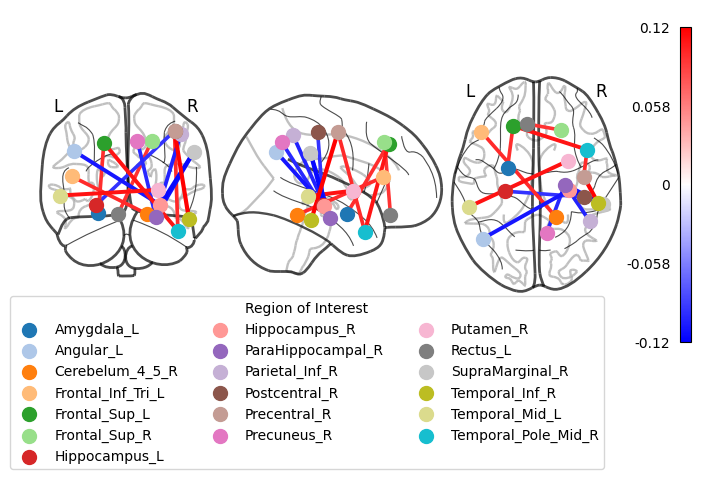

In [15]:
from nilearn.datasets import fetch_atlas_aal
from nilearn.plotting import find_parcellation_cut_coords

# Retrieve the trained model configured with all phenotypic metadata
model = trainers["all_phenotypes"]

# Fetch the AAL (Automated Anatomical Labeling) atlas
# Provides ROI labels and brain region maps
atlas = fetch_atlas_aal()

# Extract 3D MNI coordinates for each ROI in the AAL atlas
coords = find_parcellation_cut_coords(atlas.maps)

# Extract weights from the MIDA-transformed feature space (domain-adapted representation)
mida_weights = model.best_mida_.orig_coef_

# Extract weights from the final classifier (e.g., logistic regression coefficients)
classifier_weights = np.squeeze(model.best_estimator_.coef_, axis=0)

# Compute final feature-level weights by linearly combining MIDA and classifier weights
# Resulting in one scalar per connectivity feature
weights = (mida_weights @ classifier_weights).T

# Visualize the top 0.2% strongest ROI-to-ROI connections using a connectome plot
proj = visualize_connectome(
    weights=weights,
    labels=atlas.labels,       # ROI names from the AAL atlas
    coords=coords,             # ROI spatial coordinates (MNI space)
    p=0.002,                   # Visualize top 0.2% of weights by magnitude
    legend_params=dict(
        title="Region of Interest",   # Title shown above the legend
        ncols=3,                      # Organize legend entries into 3 columns
        loc="lower center",          # Legend anchor point
        bbox_to_anchor=(1.5, -1.0),  # Adjust legend position
    ),
)

# Display the resulting connectome plot
display(proj)

This plot shows the **most discriminative ROI connections** for classifying ASD vs Control subjects.
- **Red edges** indicate connections **stronger in ASD**.
- **Blue edges** indicate connections **stronger in Control**.
- Color intensity reflects the **magnitude of contribution** to the model’s decision.

---

**Key Patterns**:
- **Increased connectivity in ASD (Red**):
    - Between **frontal regions** (*Frontal_Inf_Tri_L*, *Frontal_Sup_R*) and **limbic structures** (*Hippocampus_R*, *Amygdala_L*), suggesting atypical emotional or executive function coupling.
    - **Temporal and subcortical regions** (*Temporal_Pole_Mid_R*, *Putamen_R*) are also prominent—linked to altered language, reward, or sensorimotor integration in ASD.
- **Increased connectivity in Control (Blue)**:
    - Involving **parietal and sensorimotor regions** (*Postcentral_R*, *Precuneus_R*, *Supramarginal_R*), indicating more typical integration of sensory and motor pathways.
    - Also includes **default mode and association regions** (*Angular_L*, *Parietal_Inf_R*), which are often underconnected in ASD.

The model distinguishes ASD from Control subjects by identifying **abnormal functional connections**, especially across **frontal–limbic**, **temporal–subcortical**, and **parietal–sensorimotor networks**, aligning with known neurodevelopmental differences in autism.